# Aria + MintPy Processing

1. ariaDownload.py
   - can refer to ariaDownload_tutorial.ipynb
2. ariaTSsetup.py
   - can refer to ariaTSsetup_tutorial.ipynb
3. prep_aria.py
   - prep_aria.py -w mask/watermask.msk -s stack/ -d DEM/SRTM_3arcsec.dem -i incidenceAngle/20210720_20210708.vrt -a azimuthAngle/20210720_20210708.vrt
   - reference: https://github.com/insarlab/MintPy/issues/172
4. smallbaselineApp.py
   - can refer to a_Load_HyP3_Data.ipynb
   - can refer to c_MintPy_Time_Series.ipynb

In [ ]:
from pathlib import Path
import shutil
import sys
import os

import h5py
from ipyfilechooser import FileChooser
from mintpy.cli import view, tsview, plot_network, plot_transection
import mintpy.utils
from mintpy.utils import plot, readfile
import numpy as np
import opensarlab_lib as osl

In [ ]:
os.chdir('/home/jovyan/test_aria/JupyterDocs/aria_processing')

In [ ]:
# create .netrc if it does not exist    
if not os.path.exists(os.path.expanduser('~/.netrc')):
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_user = str(earthdata_user)
    earthdata_password = input('Please type your Earthdata password:')
    earthdata_password = str(earthdata_password)
    os.system('echo machine urs.earthdata.nasa.gov login "{usern}" password "{passwd}" > ~/.netrc; chmod 600 ~/.netrc'.format( \
              usern = earthdata_user, passwd = earthdata_password))

# preview the product: -o count
#!ariaDownload.py --track 4 --bbox "36.75 37.225 -76.655 -75.928" -o count

!ariaDownload.py -t 115 --bbox "37.5259 37.8129 -122.4528 -122.055" -s 20210701 -e 20220801 -v

In [4]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

# ------------------------------------------------------------------------------------------- #
# no changed below needed:

import os, copy
import shutil
import subprocess
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
    

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.shapefile_util as shputil
except:
    raise Exception('ARIA-tools is missing from your PYTHONPATH')
        
os.chdir(work_dir)

Work directory:  /home/jovyan/test_aria/JupyterDocs/aria_processing
Tutorial directory:  /home/jovyan/test_aria/JupyterDocs/aria_processing


In [5]:
# create .topoapi if it does not exist    
if not os.path.exists(os.path.expanduser('~/.topoapi')):
    print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
    opentopography_api_key = input('Please type your OpenTopo API key:')
    opentopography_api_key = str(opentopography_api_key)
    os.system('echo "{api_key}" > ~/.topoapi; chmod 600 ~/.topoapi'.format(api_key = str(opentopography_api_key)))

API key location: My Account > myOpenTopo Authorizations and API Key > Request API key


Please type your OpenTopo API key: 879586847f8875e549345fae68e2e2aa


In [6]:
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """  'path_layer' is a string to the GDAL compatible dataset to be plotted """   
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = copy.copy(plt.cm.Greys_r)
    cmap.set_under('black')
    vmin = None
    vmax = None
    
    ## definging the plotting options for different layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmax = 2000 
   
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin, vmax = 0, 1

    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        cmap = plt.cm.coolwarm
   
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        cmap = plt.cm.terrain
    
    elif lay_type == 'ENU':
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # change colormap to a warm type
        cmap = plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent,interpolation='nearest')
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

In [ ]:
!ariaTSsetup.py -f 'products/*.nc' -b '37.5259 37.8129 -122.4528 -122.055' -d output_SRTMGL3.tif --mask Download

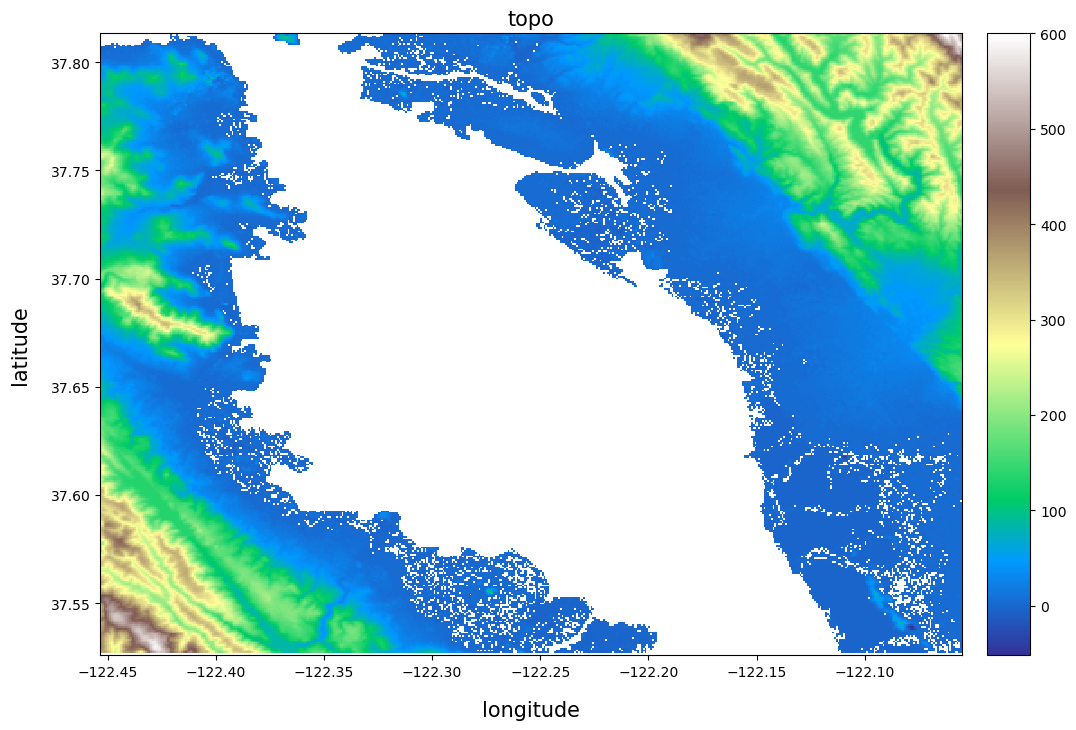

In [14]:
plot_layer('DEM/SRTM_3arcsec.dem',lay_type='topo')

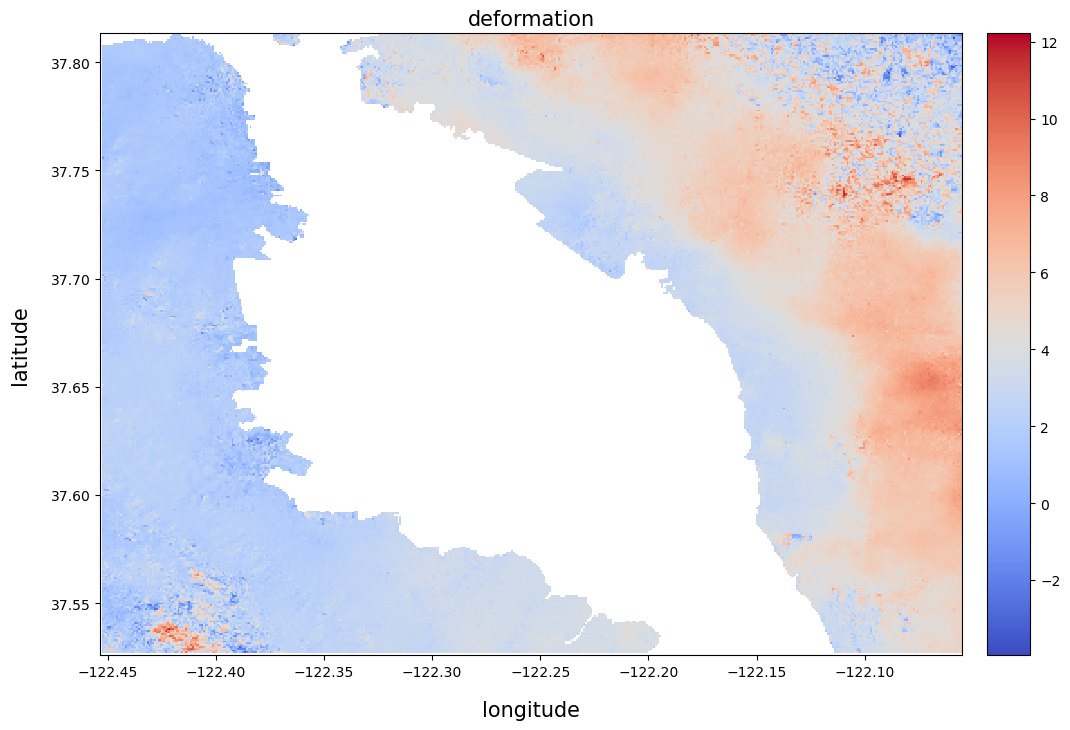

In [15]:
## view the plot
plot_layer('unwrappedPhase/20220504_20220422', 'deformation')


In [41]:
!prep_aria.py -w mask/watermask.msk -s stack/ -d DEM/SRTM_3arcsec.dem -i incidenceAngle/20210720_20210708.vrt -a azimuthAngle/20210720_20210708.vrt

multilook x/ystep: 1/1
multilook method : nearest
search input data file info:
unwFile       : /home/jovyan/test_aria/JupyterDocs/aria_processing/stack/unwrapStack.vrt
corFile       : /home/jovyan/test_aria/JupyterDocs/aria_processing/stack/cohStack.vrt
connCompFile  : /home/jovyan/test_aria/JupyterDocs/aria_processing/stack/connCompStack.vrt
demFile       : DEM/SRTM_3arcsec.dem
incAngleFile  : incidenceAngle/20210720_20210708.vrt
azAngleFile   : azimuthAngle/20210720_20210708.vrt
waterMaskFile : mask/watermask.msk
update mode: False
extract metadata from /home/jovyan/test_aria/JupyterDocs/aria_processing/stack/unwrapStack.vrt
--------------------------------------------------
create HDF5 file: ./inputs/ifgramStack.h5 with w mode
create dataset  : date             of |S8                       in size of (81, 2)              with compression = None
create dataset  : dropIfgram       of <class 'numpy.bool_'>     in size of (81,)                with compression = None
create dataset  : bp

In [42]:
!smallbaselineApp.py mintpy/SanFranSen115.txt --dostep load_data

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 17:48:26.069208--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSen115
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
read custom template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/SanFranSen115.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_process

In [43]:
!smallbaselineApp.py mintpy/SanFranSen115.txt --dostep modify_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 17:50:26.781952--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSen115
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
read custom template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/SanFranSen115.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbase

read temporal/spatial baseline info from file: /home/jovyan/test_aria/JupyterDocs/aria_processing/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
calculating spatial mean of coherence in file /home/jovyan/test_aria/JupyterDocs/aria_processing/inputs/ifgramStack.h5 ...
[==================================================] 81/81    0s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 30
number of interferograms: 81
shift all perp baseline by -1.2599879503250122 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 81
number of acquisitions marked as drop: 0
max perpendicular baseline: 218.76 m
max temporal      baseline: 36.0 days
showing coherence
data range: [0.6698, 0.9512]
display range: (0.2, 1.0)
showing ...


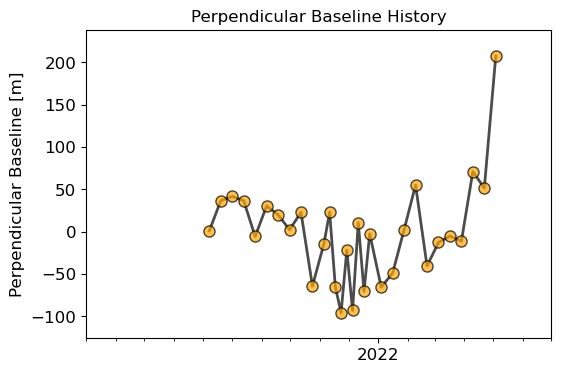

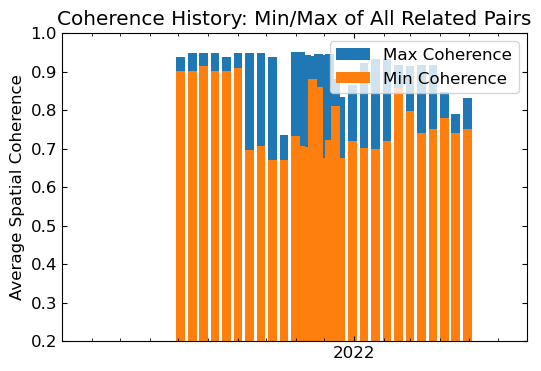

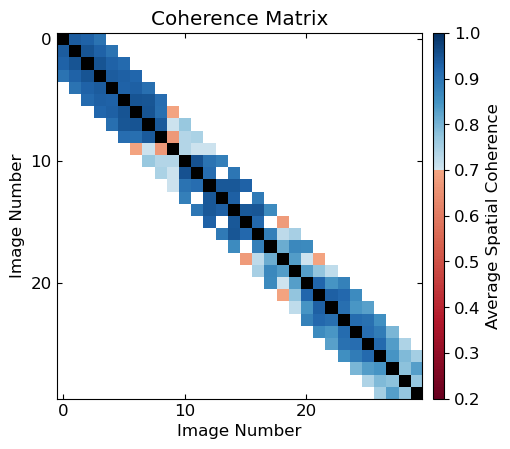

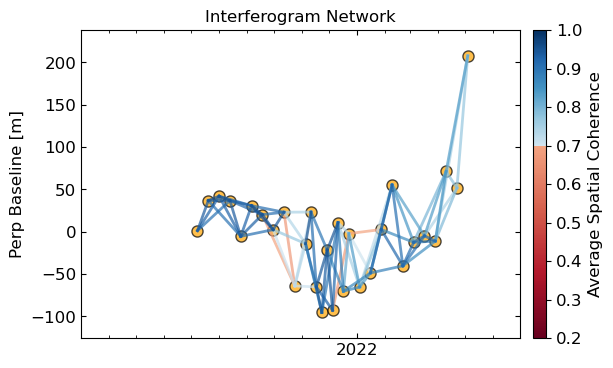

In [48]:
mint_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy'
inputs_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/inputs'
import opensarlab_lib as osl
from mintpy.cli import plot_network

%matplotlib inline
with osl.work_dir(mint_path):
    scp_args = f'{inputs_path}/ifgramStack.h5 --cmap-vlist 0.2 0.7 1.0'
    plot_network.main(scp_args.split())
    plots = ['pbaseHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']

In [49]:
!smallbaselineApp.py mintpy/SanFranSen115.txt --dostep reference_point

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 17:56:22.753668--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSen115
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
read custom template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/SanFranSen115.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg


****

In [50]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                                         37.690401590499995
  REF_LON                                         -122.07036783849999
  REF_X                                           459
  REF_Y                                           147


In [51]:
!smallbaselineApp.py mintpy/SanFranSen115.txt --dostep quick_overview

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 17:57:26.922070--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSen115
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
read custom template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/SanFranSen115.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg


******************** st

plot and save figure to file numTriNonzeroIntAmbiguity.png


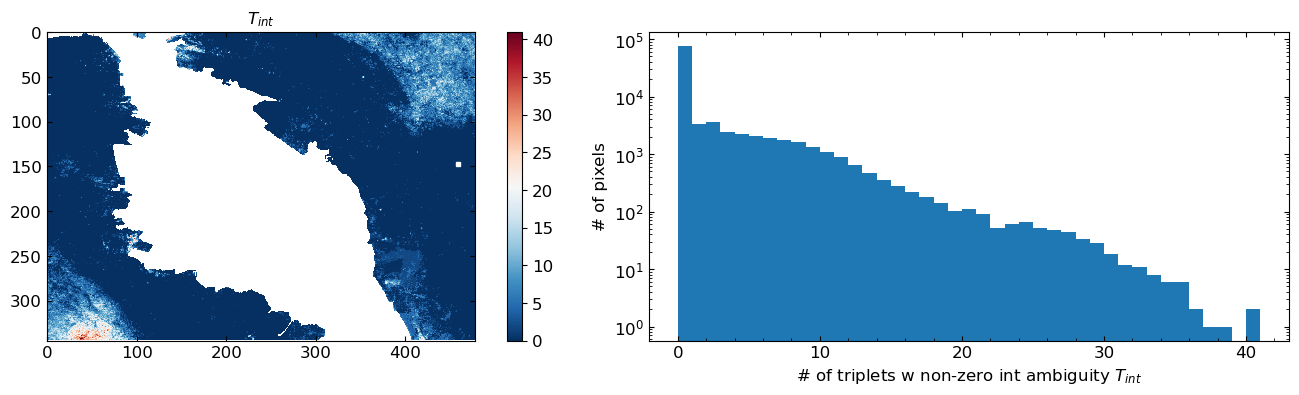

In [59]:
import mintpy.utils
from mintpy.utils import plot, readfile

plot.plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', disp_fig=True, fig_size=[14, 4])

In [5]:
import os
os.chdir('/home/jovyan/test_aria/JupyterDocs/aria_processing')
!smallbaselineApp.py /home/jovyan/test_aria/JupyterDocs/aria_processing/smallbaselineApp.cfg --work-dir mintpy --dostep invert_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:23:28.208385--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - invert_network ********************
Input data seems to be geocoded. Lookup file not needed.

ifgram_inversion.py /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/inputs/ifgramStack.h5 -t /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg --update
read input option from template file:

In [ ]:
mint_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy'
inputs_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/inputs'

era5_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/ERA5'
timeseries_era5_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5.h5'
inputs_era5_path = '/home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/inputs/ERA5.h5'

# Delete old tropospheric data if it exists
# to allow MintPy to rerun tropospheric_correction
try:
    shutil.rmtree(era5_path)
except FileNotFoundError:
    pass
    
!smallbaselineApp.py --work-dir mintpy --dostep correct_troposphere

In [16]:
!smallbaselineApp.py --work-dir mintpy --dostep correct_topography

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:42:50.991037--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - correct_topography ********************
Input data seems to be geocoded. Lookup file not needed.

dem_error.py /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5.h5 -t /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg -o /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5_demErr.h5 --update -g /home/jovyan/test_aria/JupyterDocs

In [17]:
!smallbaselineApp.py --work-dir mintpy --dostep residual_RMS

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:43:29.204392--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - residual_RMS ********************

timeseries_rms.py timeseriesResidual.h5 -t /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg
read options from template file: smallbaselineApp.cfg
remove quadratic ramp from file: timeseriesResidual.h5
read mask file: maskTempCoh.h5
--------------------------------------------------
grab metadata from ref_file: timeseriesResidual.h5
grab dataset structure fro

In [18]:
!smallbaselineApp.py --work-dir mintpy --dostep reference_date

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:43:51.190217--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py -t /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries.h5 /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5.h5 /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5_demErr.h5
read reference date from file: reference_date.txt
input reference date:

In [19]:
!smallbaselineApp.py --work-dir mintpy --dostep velocity

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:44:14.453028--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5_demErr.h5 -t /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg -o /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/velocity.h5 --update
read options from template file: smallbaselineApp.cfg
update mode: ON
1) output file /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/velocity.h5 NO

In [22]:
!smallbaselineApp.py --work-dir mintpy --dostep geocode

1622.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:46:14.172504--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - geocode ********************
dataset is geocoded, skip geocoding and continue.
Go back to directory: /home/jovyan/test_aria/JupyterDocs/aria_processing

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 0.0 secs



In [23]:
!smallbaselineApp.py --work-dir mintpy  --dostep google_earth

1650.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-22 18:46:41.690594--
Current directory: /home/jovyan/test_aria/JupyterDocs/aria_processing
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy
read default template file: /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/velocity.h5 -o /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/velocity.kmz
data   coverage in y/x: (0, 0, 478, 345)
subset coverage in y/x: (0, 0, 478, 345)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/478/345
update Y/X_FIRST
update REF_Y/X
read mask from file: maskTempCoh.h

In [ ]:
!save_kmz.py /home/jovyan/la2_test/MintPy/velocity.h5 -o /home/jovyan/la2_test/MintPy/velocity.kmz

In [24]:
!save_kmz_timeseries.py /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/timeseries_ERA5_demErr.h5

1771.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


open timeseries file: timeseries_ERA5_demErr.h5
input data shape in row/col: 345/478
writing /home/jovyan/test_aria/JupyterDocs/aria_processing/mintpy/google_earth_cbar.png
add reference point.
------------------------------
step: 20 pixels
number of output boxes: 1
create KML doc for box 1/1: (0, 0, 478, 345), step: 20 pixels, 391 pixels in total ...
create KML region links directory: 20by20
------------------------------
step: 5 pixels
number of output boxes: 4
create KML doc for box 1/4: (0, 0, 250, 250), step: 5 pixels, 2500 pixels in total ...
create KML doc for box 2/4: (250, 0, 478, 250), step: 5 pixels, 2250 pixels in total ...
create KML doc for box 3/4: (0, 250, 250, 345), step: 5 pixels, 950 pixels in total ...
create KML doc for box 4/4: (250, 250, 478, 345), step: 5 pixels, 855 pixels in total ...
create KML region links directory: 5by5
------------------------------
get boxes on deforming areas with step: 2 pixels
removing a quadratic phase ramp from input velocity before